P1_f1_alto → Índice: 6, f1: 170.00, f2: 1568.02, a3: 7.47, a4: 108
P2_f2_alto → Índice: 9, f1: 734.00, f2: 1140.97, a3: 0.30, a4: 111
P3_a3_alto → Índice: 11, f1: 295.00, f2: 1444.02, a3: 2.69, a4: 107


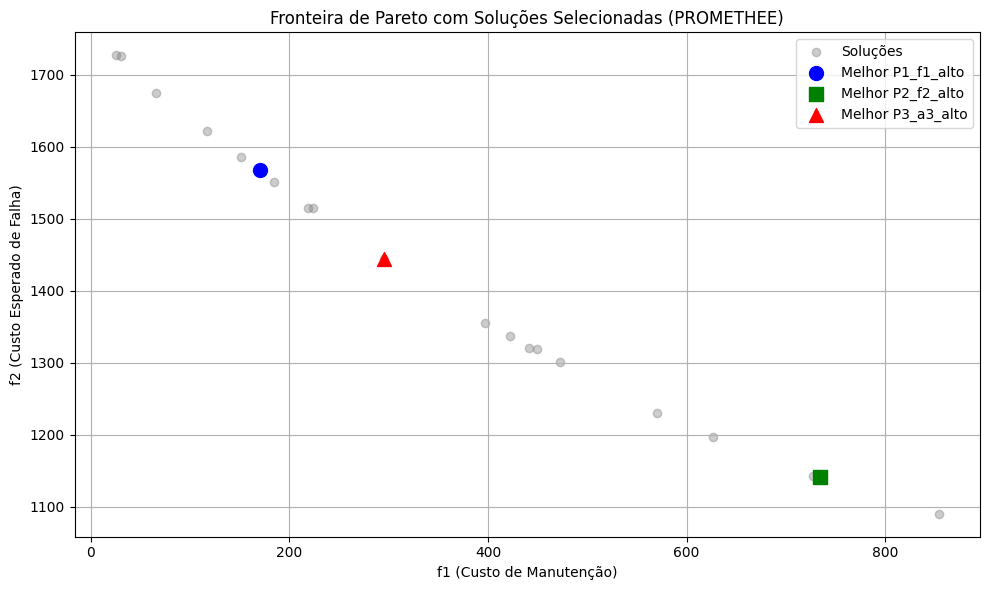

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- CONFIGURAÇÕES -----------------------------
CORES_PLANOS = ["lightblue", "lightgreen", "lightpink"]
NOMES_CLUSTERS = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

CSV_SOLUCOES = "resultados_pareto_epsilon_rest_penalidade_2025-06-23_01-34-10.csv"
PATH_EQUIP = "arquivos_tc/EquipDB.csv"
PATH_CLUSTER = "arquivos_tc/ClusterDB.csv"
PATH_PLANOS = "arquivos_tc/MPDB.csv"

# ----------------------------- CARREGAMENTO DE DADOS -----------------------------
df_sol = pd.read_csv(CSV_SOLUCOES)
equip_db = pd.read_csv(PATH_EQUIP, header=None)
cluster_db = pd.read_csv(PATH_CLUSTER, header=None)
mp_db = pd.read_csv(PATH_PLANOS, header=None)

N = equip_db.shape[0]
J = 3

# ----------------------------- FUNÇÕES AUXILIARES -----------------------------
def weibull_cdf(t, eta, beta):
    return 1 - np.exp(-(t / eta) ** beta)

def calcular_atributos(df_sol):
    delta_t = 5
    d_i = equip_db.iloc[:, 3].values

    matriz_custo_esperado = np.zeros((N, J))
    for i in range(N):
        t0 = equip_db.iloc[i, 1]
        cid = int(equip_db.iloc[i, 2])
        eta = cluster_db.loc[cluster_db[0] == cid, 1].values[0]
        beta = cluster_db.loc[cluster_db[0] == cid, 2].values[0]
        for j in range(J):
            k = mp_db.iloc[j, 1]
            numer = weibull_cdf(t0 + k * delta_t, eta, beta) - weibull_cdf(t0, eta, beta)
            denom = 1 - weibull_cdf(t0, eta, beta)
            p = numer / denom
            matriz_custo_esperado[i, j] = p * d_i[i]

    c_j = mp_db.iloc[:, 2].values
    f1_list, f2_list, a3_list, a4_list = [], [], [], []

    for _, row in df_sol.iterrows():
        planos = row.values.astype(int)
        f1 = np.sum(c_j[planos - 1])
        f2 = sum(matriz_custo_esperado[i, planos[i] - 1] for i in range(N))
        n_m1 = np.sum(planos == 1)
        n_m3 = np.sum(planos == 3)
        a3 = 100 if n_m3 == 0 else n_m1 / n_m3
        cluster_ids = equip_db.iloc[:, 2].values.astype(int)
        a4 = np.sum((cluster_ids == 1) & (planos == 3)) + np.sum((cluster_ids == 4) & (planos == 1))
        f1_list.append(f1)
        f2_list.append(f2)
        a3_list.append(a3)
        a4_list.append(a4)

    df_sol['f1'] = f1_list
    df_sol['f2'] = f2_list
    df_sol['a3'] = a3_list
    df_sol['a4'] = a4_list
    return df_sol

def promethee_ii(matriz, pesos):
    n = matriz.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                P[i, j] = np.dot(pesos, np.maximum(0, matriz[j] - matriz[i]))
    phi_p = P.sum(axis=1) / (n - 1)
    phi_m = P.sum(axis=0) / (n - 1)
    return phi_p - phi_m

# ----------------------------- PROCESSAMENTO -----------------------------
df_sol = calcular_atributos(df_sol)
nd = df_sol.drop_duplicates(['f1', 'f2']).reset_index(drop=True)
if len(nd) > 20:
    df = nd.sample(20, random_state=42).reset_index(drop=True)
else:
    df = nd.copy()

# Normalização
df['f1_norm'] = (df['f1'] - df['f1'].min()) / (df['f1'].max() - df['f1'].min())
df['f2_norm'] = (df['f2'] - df['f2'].min()) / (df['f2'].max() - df['f2'].min())
df['a3_norm'] = np.abs(df['a3'] - 1)
df['a3_norm'] = (df['a3_norm'] - df['a3_norm'].min()) / (df['a3_norm'].max() - df['a3_norm'].min())
df['a4_norm'] = (df['a4'] - df['a4'].min()) / (df['a4'].max() - df['a4'].min())

# ----------------------------- AVALIAÇÕES COM DIFERENTES PESOS -----------------------------
pesos_variacoes = {
    "P1_f1_alto": [0.50, 0.20, 0.20, 0.10],
    "P2_f2_alto": [0.10, 0.50, 0.20, 0.20],
    "P3_a3_alto": [0.10, 0.10, 0.70, 0.10],
}

melhores_solucoes = {}

for nome, pesos in pesos_variacoes.items():
    matriz = df[['f1_norm', 'f2_norm', 'a3_norm', 'a4_norm']].values
    df[f'PROMETHEE_{nome}'] = promethee_ii(matriz, np.array(pesos))
    idx = df[f'PROMETHEE_{nome}'].idxmax()
    melhores_solucoes[nome] = idx

    # Print resumo da melhor solução
    print(f"{nome} → Índice: {idx}, f1: {df.loc[idx, 'f1']:.2f}, f2: {df.loc[idx, 'f2']:.2f}, a3: {df.loc[idx, 'a3']:.2f}, a4: {df.loc[idx, 'a4']}")

# ----------- Plot Único da Fronteira com todas as melhores soluções -----------
plt.figure(figsize=(10, 6))
plt.scatter(df['f1'], df['f2'], alpha=0.4, label='Soluções', color='gray')

cores = ['blue', 'green', 'red']
marcadores = ['o', 's', '^']

for i, (nome, idx) in enumerate(melhores_solucoes.items()):
    plt.scatter(df.loc[idx, 'f1'], df.loc[idx, 'f2'],
                color=cores[i], marker=marcadores[i], s=100,
                label=f'Melhor {nome}')

plt.xlabel('f1 (Custo de Manutenção)')
plt.ylabel('f2 (Custo Esperado de Falha)')
plt.title('Fronteira de Pareto com Soluções Selecionadas (PROMETHEE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

